# Manipulate LondonAir gridded (modelled) concentrations data to LSOA

Part of [london-data](https://github.com/jamesdamillington/london-data), by [jamesdamillington](https://github.com/jamesdamillington)

## Aim
Summarise [LondonAir air quality data](https://data.london.gov.uk/air-quality/) from 20m grid to London LSOAs. 

Inputs are `.asc` ESRI ASCII grid data for different pollutants. Outputs will be `.csv` with LOSA-by-row that can be readily joined to [ONS Geographies data](https://github.com/jamesdamillington/london-data/tree/main/data/geographies/census). 

In [2]:
from datetime import date
print(f'Last tested: {date.today()}')

Last tested: 2023-11-09


In [1]:
import geopandas as gpd
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import rasterio as rio
from rasterio.plot import show
from rasterstats import zonal_stats

## Get Geography

Read geographies for regions to summarise grid onto:

[London 2011 LSOA census geography](https://github.com/jamesdamillington/london-data/tree/main/data/geographies/census) 

[Generalised (20m) LSOA geometries](https://geoportal.statistics.gov.uk/datasets/ons::lower-layer-super-output-areas-2021-boundaries-ew-bgc/explore) (clipped to the coastline) data downloaded [2023-08-15] as *Lower_layer_Super_Output_Areas_2021_EW_BGC_V3_7972316521517759310.zip*

> Source: Office for National Statistics licensed under the Open Government Licence v.3.0  
Contains OS data © Crown copyright and database right (2022)
Contains both Ordnance Survey and ONS Intellectual Property Rights.

In [5]:
census_path = Path("../data/geographies/census/")
london11 = gpd.read_file(census_path/"london-2011-lsoa.shp")
london11 = london11.set_index(london11.LSOA11CD)

london21 = gpd.read_file(census_path/"london-2021-lsoa-gen20.shp")
london21 = london21.set_index(london21.LSOA21CD)

## Data

Original data downloaded [2022-09-06] are:
- 2019 Concentrations - [Data](https://data.london.gov.uk/download/london-atmospheric-emissions-inventory--laei--2019/173ed1c2-26c4-4286-96d8-12da40a0c94f/LAEI2019-Concentrations-Data-ASCII.zip) - ASCII Files (.ZIP - 132.2 MB) _"This dataset includes modelled 2019 ground level concentrations of annual mean NOx, NO2, PM10 and PM2.5 in µg/m3 (microgramme per cubic metre) at 20m grid resolution. For PM10, it also includes the number of daily means exceeding 50 µg/m3."_ [source](https://data.london.gov.uk/dataset/london-atmospheric-emissions-inventory--laei--2019)
- 2016  Concentrations - [Data](https://data.london.gov.uk/download/london-atmospheric-emissions-inventory--laei--2016/924b02c9-bc9c-4fb4-b3aa-0783b9fd84e8/LAEI_2016_Concentrations_Data_ASCII.zip) - ASCII Files (.ZIP - 86.4MB) _"This dataset includes modelled 2016 ground level concentrations of annual mean NOx, NO2, PM10 and PM2.5 in µg/m3 (microgramme per cubic metre) at 20m grid resolution. For PM10, it also includes the number of daily means exceeding 50 µg/m3."_ [source](https://data.london.gov.uk/dataset/london-atmospheric-emissions-inventory--laei--2016)
- 2013 Concentrations - [Data](https://files.datapress.com/london/dataset/london-atmospheric-emissions-inventory-2013/2017-01-26T18:50:00/4.1.%20Concentrations%20LAEI%202013%20Update.zip) - LAEI 2013 Update  (.ZIP - 767.837 KB) - _"Modelled 2013 and 2020 concentrations of NO2, NOx, PM10, PM10d and PM2.5 at 20m grid level. 04/04/2017 - Please note this file contains updated revised LAEI 2013 concentration data which should now replace files previously provided for 2013 and 2020."_ [source](https://data.london.gov.uk/dataset/london-atmospheric-emissions-inventory-2013) (NB: data from 2013/ASCII/ folder within zip)

> Source: London Atmospheric Emissions Inventory (LAEI) licensed under the [Open Government Licence v.2.0](https://www.nationalarchives.gov.uk/doc/open-government-licence/version/2/)  


In [6]:
aq_ipath = Path("../data/inputs/airquality/")

## Demo

In [7]:
pm25_2019 = rio.open(aq_ipath/"laei_LAEI2019v3_CorNOx15_PM25.asc")

In [8]:
pm25_2019.meta

{'driver': 'AAIGrid',
 'dtype': 'float32',
 'nodata': -9999.0,
 'width': 3026,
 'height': 2555,
 'count': 1,
 'crs': None,
 'transform': Affine(20.0, 0.0, 501470.0,
        0.0, -20.0, 203450.0)}

Visually check spatial alignment

<AxesSubplot:>

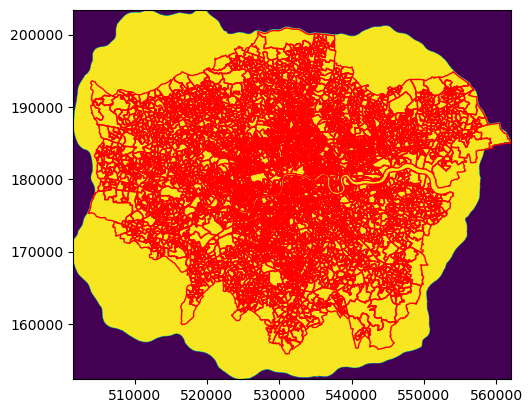

In [9]:
fig,ax1=plt.subplots(1)
show((pm25_2019,1), cmap='viridis',ax=ax1)  #rasterio show, reading the first layer from the DatasetReader object
london21.plot(ax=ax1, facecolor='None', edgecolor='red', linewidth=1)

Calculate zonal statistics (i.e summarise raster by polygon regions)

In [10]:
%%time
zs21_pm25_2019 = zonal_stats(london21, pm25_2019.read(1),   #input 2d raster (dataset reader is 3D)
                           affine=pm25_2019.meta['transform'],  
                           nodata=pm25_2019.meta['nodata'],
                           stats=['min', 'max', 'mean', 'median', 'std'],
                           prefix="PM25_2019_")

CPU times: user 14.8 s, sys: 20.7 s, total: 35.6 s
Wall time: 1min 11s


In [11]:
zs21_pm25_2019pd = pd.DataFrame(zs21_pm25_2019)   #convert dict to pandas df
zs21_pm25_2019pd.set_index(london21.index,inplace=True)   #set index for merge below

Merge and plot

<AxesSubplot:>

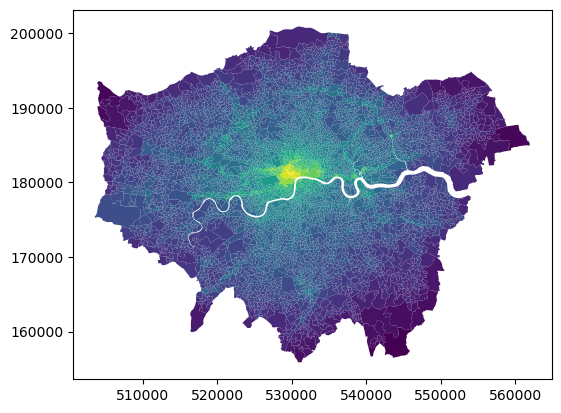

In [12]:
london21_pm25_2019 = london21.merge(zs21_pm25_2019pd, left_index=True, right_index=True)
london21_pm25_2019.plot('PM25_2019_mean')

## Implementation

In [13]:
aq_opath = Path("../data/airquality/")

Function collapsing the demo code above for looping over multuple pollutants

In [14]:
def summarise_aq_raster(london_geo, rio_dr, label):
    print("Calculating zonal stats for " + label)
    zs_dict = zonal_stats(london_geo, rio_dr.read(1),    #input 2d raster (dataset reader is 3D)
                           affine=rio_dr.meta['transform'],
                           nodata=rio_dr.meta['nodata'],
                           stats=['min', 'max', 'mean', 'median', 'std'],
                           prefix=label)
    zs_pd = pd.DataFrame(zs_dict)
    zs_pd.set_index(london_geo.index,inplace=True)
    zs_pd=zs_pd.round(3)
    return zs_pd

In [15]:
#dict to use in loops below  (label:filename)
dict_2019 = {
    "PM25":"laei_LAEI2019v3_CorNOx15_PM25.asc",
    "PM10":"laei_LAEI2019v3_CorNOx15_PM10m.asc",
    "PM10d":"laei_LAEI2019v3_CorNOx15_PM10d.asc",
    "NOx":"laei_LAEI2019v3_CorNOx15_NOx.asc",
    "NO2":"laei_LAEI2019v3_CorNOx15_NO2.asc"
}

In [16]:
for k, v in dict_2019.items():
    rio_dr_2019 = rio.open(aq_ipath/"ASCII-2019"/v)
    pd2019 = summarise_aq_raster(london21, rio_dr_2019, "{0}-2019-".format(k))
    pd2019.to_csv(aq_opath/"london21-2019-{0}.csv".format(k))

Calculating zonal stats for PM25-2019-
Calculating zonal stats for PM10-2019-
Calculating zonal stats for PM10d-2019-
Calculating zonal stats for NOx-2019-
Calculating zonal stats for NO2-2019-


In [17]:
#dict to use in loops below  (label:filename)
dict_2016 = {
    "PM25":"LAEI2016_2016_PM25.asc",
    "PM10":"LAEI2016_2016_PM10.asc",
    "PM10d":"LAEI2016_2016_PM10d.asc",
    "NOx":"LAEI2016_2016_NOx.asc",
    "NO2":"LAEI2016_2016_NO2.asc"
}

In [18]:
for k, v in dict_2016.items():
    rio_dr_2016 = rio.open(aq_ipath/"ASCII-2016"/v)
    pd2016 = summarise_aq_raster(london21, rio_dr_2016, "{0}-2016-".format(k))
    pd2016.to_csv(aq_opath/"london21-2016-{0}.csv".format(k))

Calculating zonal stats for PM25-2016-
Calculating zonal stats for PM10-2016-
Calculating zonal stats for PM10d-2016-
Calculating zonal stats for NOx-2016-
Calculating zonal stats for NO2-2016-


In [19]:
#dict to use in loops below  (label:filename)
dict_2013 = {
    "PM25":"PostLAEI2013_2013_PM25.asc",
    "PM10":"PostLAEI2013_2013_PM10.asc",
    "PM10d":"PostLAEI2013_2013_PM10d.asc",
    "NOx":"PostLAEI2013_2013_NOx.asc",
    "NO2":"PostLAEI2013_2013_NO2.asc"
}

In [20]:
for k, v in dict_2013.items():
    rio_dr_2013 = rio.open(aq_ipath/"ASCII-2013"/v)
    pd2013 = summarise_aq_raster(london21, rio_dr_2013, "{0}-2013-".format(k))
    pd2013.to_csv(aq_opath/"london21-2013-{0}.csv".format(k))

Calculating zonal stats for PM25-2013-
Calculating zonal stats for PM10-2013-
Calculating zonal stats for PM10d-2013-
Calculating zonal stats for NOx-2013-
Calculating zonal stats for NO2-2013-
